# Sobol indices

In [1]:
import openturns as ot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from shapley.plots import set_style_paper, plot_sensitivity_results
set_style_paper()

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Gaussian Framework

In [2]:
from shapley.tests import AdditiveGaussian, Ishigami

Model = AdditiveGaussian

if Model == AdditiveGaussian:
    dim = 3
    beta = None
    model = Model(dim=dim, beta=beta)
    model.margins = [ot.Normal()]*(dim-1) + [ot.Normal(0, 2.)]
    theta = [0., 0., 0.5]
    model.copula_parameters = theta
elif Model == Ishigami:
    model = Model()
    dim = model.dim
    model.copula = ot.NormalCopula(dim)
    theta = [0., 0., 0.]

### Monte-Carlo estimation using true model

In [3]:
%%time
from shapley import ShapleyIndices
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

n_perms = None
n_var = 1000
n_outer = 100
n_inner = 3

budget_perms = np.math.factorial(dim) if n_perms is None else n_perms
max_budget = n_var + n_outer * n_inner * budget_perms * (dim - 1)
print('Max budget:', max_budget)

shapley = ShapleyIndices(model.input_distribution)
shapley.build_sample(model=model, n_perms=n_perms, n_var=n_var, n_outer=n_outer, n_inner=n_inner)

Max budget: 4600
Wall time: 1.16 s


In [4]:
%%time
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

n_boot = 500
shapley_results = shapley.compute_indices(n_boot=n_boot)
shapley_results._first_indices = None
shapley_results._total_indices = None

Wall time: 182 ms


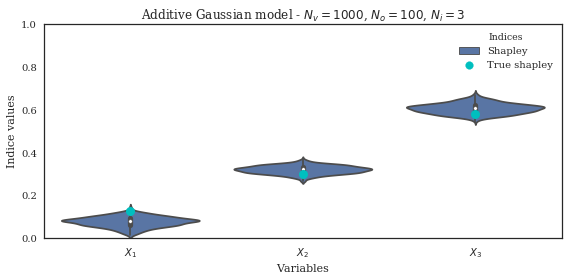

In [5]:
from shapley.plots import plot_sensitivity_results
ylim = [0., 1.]

fig, ax = plt.subplots(figsize=(8, 4))
plot_sensitivity_results(shapley_results, indice='all', ax=ax)
ax.set_title("{} model - $N_v={}$, $N_o={}$, $N_i={}$".format(
    model.name, n_var, n_outer, n_inner))
ax.set_ylim(ylim)
fig.tight_layout()

### Monte-Carlo estimation using a Kriging model

In [37]:
from shapley.kriging import KrigingModel
ot.RandomGenerator.SetSeed(11)
np.random.seed(11)

if Model == AdditiveGaussian:
    model_budget = 10
    library = 'sklearn'
elif Model == Ishigami:
    model_budget = 200
    library = 'gpflow'

sampling = 'lhs'
kernel = 'matern'
basis = 'linear'

model_gp = KrigingModel(model=model, input_distribution=model.input_distribution)
model_gp.generate_sample(n_sample=model_budget, sampling=sampling, sampling_type='uniform')
model_gp.build(library=library, kernel=kernel, basis_type=basis)

# The score of the meta_model
q2_score_cv_gp = model_gp.compute_score_q2_cv(n_sample=10000, sampling='monte-carlo')
print('Q2-score by cross-validation:', q2_score_cv_gp)

Q2-score by cross-validation: 0.908789292749


In [38]:
%%time
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

n_realization = 300
shapley.build_sample(model=model_gp, n_perms=n_perms, n_var=n_var,
                     n_outer=n_outer, n_inner=n_inner, n_realization=n_realization)

Wall time: 31.5 s


In [39]:
%%time
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

shapley_gp_results = shapley.compute_indices(n_boot=n_boot)
shapley_gp_results._first_indices = None
shapley_gp_results._total_indices = None

Wall time: 19.6 s


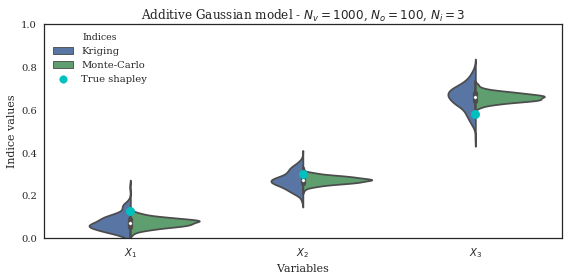

In [40]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_sensitivity_results(shapley_gp_results, indice='shapley', ax=ax)
ax.set_title("{} model - $N_v={}$, $N_o={}$, $N_i={}$".format(
    model.name, n_var, n_outer, n_inner))
ax.set_ylim(ylim)
fig.tight_layout()

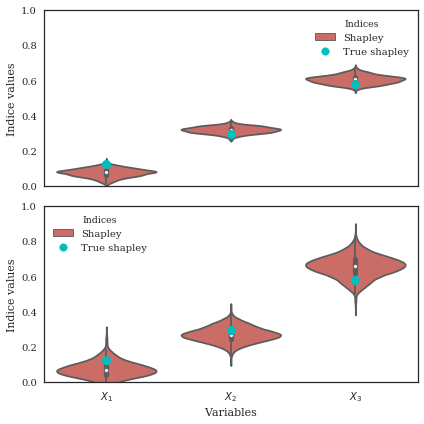

In [42]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True, sharey=True)

ax = axes[0]
plot_sensitivity_results(shapley_results, indice='all', ax=ax)
ax.set_xlabel('')
ax.set_ylim(ylim)

ax = axes[1]
plot_sensitivity_results(shapley_gp_results, indice='all', ax=ax)
ax.set_ylim(ylim)
#ax.legend([])
fig.tight_layout()

fig.savefig('./output/shapleyGP_%s.pdf' % (model.name))